# Jacobian vs. Perturbation
Visualizing and Understanding Atari Agents | Sam Greydanus | 2017 | MIT License

In [2]:
from __future__ import print_function
import warnings ; warnings.filterwarnings('ignore') # mute warnings, live dangerously

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib as mpl ; mpl.use("Agg")
import pandas as pd
import h5py 

import torch
from torch.autograd import Variable
import torch.nn.functional as F

import gym, os, sys, time, argparse
sys.path.append('..')
from visualize_atari import *

## Load agent, build environment, play an episode

In [13]:
!ls ../baby-a3c/breakout-v4/

breakout-v4.gif			       model.40.tar
log-model7-02-17-20-41.txt	       model7_models.tar.gz
log-modelLog1000-2019-02-05 03:38.txt  model.80.tar
log-modelTest4-02-10-22-28.txt	       models_model7-02-17-20-41
log.txt


In [7]:
env_name = 'Breakout-v0'
save_dir = 'figures/'
load_dir = '../baby-a3c/breakout-v4/models_model7-02-17-20-41/'
def get_rollout(it):
    print("set up dir variables and environment...")
    #load_dir = '{}/'.format(env_name.lower())
    
    meta = get_env_meta(env_name)
    env = gym.make(env_name) ; env.seed(1)

    print("initialize agent and try to load saved weights...")
    model = NNPolicy(channels=1, num_actions=env.action_space.n, memsize=256)
    _ = model.try_load(load_dir, checkpoint='*'+str(it)+'.tar') ; torch.manual_seed(1)

    print("get a rollout of the policy...")
    history = rollout(model, env, max_ep_len=3e3)
    return model, history

## Store rollouts into h5 file

In [3]:
if 'model_rollouts.h5' not in os.listdir('.'):
    store = h5py.File('model_rollouts.h5','w')
else:
    store = h5py.File('model_rollouts.h5','r')

In [11]:
exceptions = []
for model in os.listdir(load_dir):
    iteration = model.split('.')[-2]
    try:
        _, history = get_rollout(iteration)
    except:
        exceptions.append(iteration)
        continue
    path = 'models_model7-02-17-20-41' 
    for k in history.keys():
        target = np.stack(history[k], axis=0)
        store.create_dataset(os.path.join(path, model, 'history', k), data = target)
        
exceptions

set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.50.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.97.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.42.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.16.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.14.tar
get a rollout of the policy...
set u

set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.81.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.69.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.90.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.30.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.96.tar
get a rollout of the policy...
set u

initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.70.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.51.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.73.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.25.tar
get a rollout of the policy...
set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.100.tar
get a rollout of the policy...
set up dir variables and environment...
init

['15']

# preview a rollout

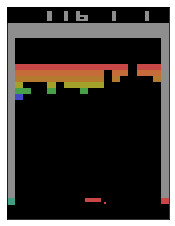

In [4]:
store = h5py.File('model_rollouts.h5','r')
ins = store['models_model7-02-17-20-41/model.50.tar/history/ins'].value
store.close()
f = plt.figure(figsize=[3,3*1.3])
# frame_ix = 1404
frame_ix= 2105
plt.imshow(ins[frame_ix])
for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)


## Get Jacobian saliency map

In [29]:
def jacobian(model, layer, top_dh, X):
    global top_h_ ; top_h_ = None
    def hook_top_h(m, i, o): global top_h_ ; top_h_ = o.clone()
    hook1 = layer.register_forward_hook(hook_top_h)
    _ = model(X) # do a forward pass so the forward hooks can be called

    # backprop positive signal
    torch.autograd.backward(top_h_, top_dh.clone(), retain_graph=True) # backward hooks are called here
    #torch.autograd.backward(top_h_, top_dh.clone())
    hook1.remove()
    return X[0].grad.data.clone().numpy(), X[0].data.clone().numpy()

# derivative is simply the output policy distribution
top_dh_actor = torch.Tensor(history['logits'][frame_ix]).view(1,-1)
top_dh_critic = torch.Tensor(history['values'][frame_ix]).view(1,-1).fill_(1)
print(top_dh_actor)
print(top_dh_critic)
print(torch.Tensor(history['values'][frame_ix]).view(1,-1).fill_(2))
top_dh_critic = torch.tensor([[1., 1., 1., 1.]])
# get input
tens_state = torch.Tensor(prepro(history['ins'][frame_ix]))
state = Variable(tens_state.unsqueeze(0), requires_grad=True)
hx = Variable(torch.Tensor(history['hx'][frame_ix-1]).view(1,-1))
#cx = Variable(torch.Tensor(history['cx'][frame_ix-1]).view(1,-1))
#X = (state, (hx, cx))
X = (state, hx)

actor_jacobian, _ = jacobian(model, model.actor_linear, top_dh_actor, X)

state.grad.mul_(0) ; X = (state, hx)
critic_jacobian, _ = jacobian(model, model.critic_linear, top_dh_critic, X)

tensor([[5.6098, 5.9915, 7.3857, 4.6897]])
tensor([[1.]])
tensor([[2.]])


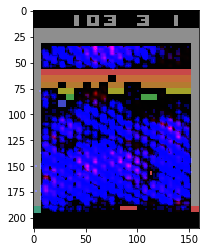

In [30]:
# upsample jacobian saliencies
frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame((actor_jacobian**2).squeeze(), frame, fudge_factor=1, channel=2, sigma=0)
jacobian_map = saliency_on_atari_frame((critic_jacobian**2).squeeze(), frame, fudge_factor=15, channel=0, sigma=0)

plt.imshow(jacobian_map)

## Get perturbation saliency map

In [22]:
model, history = get_rollout(80)


set up dir variables and environment...
initialize agent and try to load saved weights...
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.80.tar
get a rollout of the policy...


In [23]:
def score_frame(model, history, ix, r, d, interp_func, mode='actor'):
    # r: radius of blur
    # d: density of scores (if d==1, then get a score for every pixel...
    #    if d==2 then every other, which is 25% of total pixels for a 2D image)
    assert mode in ['actor', 'critic'], 'mode must be either "actor" or "critic"'
    L = run_through_model(model, history, ix, interp_func, mask=None, mode=mode)
    
    scores = np.zeros((int(80/d)+1,int(80/d)+1)) # saliency scores S(t,i,j)
    for i in range(0,80,d):
        for j in range(0,80,d):
            mask = get_mask(center=[i,j], size=[80,80], r=r)
            l = run_through_model(model, history, ix, interp_func, mask=mask, mode=mode)
            #print((L-l).pow(2).sum().mul_(.5).item())
            #scores[int(i/d),int(j/d)] = (L-l).pow(2).sum().mul_(.5).data[0]
            scores[int(i/d),int(j/d)] = (L-l).pow(2).sum().mul_(.5).item()
    pmax = scores.max()
    scores = imresize(scores, size=[80,80], interp='bilinear').astype(np.float32)
    return pmax * scores / scores.max()

In [24]:
radius = 5
density = 5
frame_ix = 1800

actor_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='actor')
critic_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='critic')

In [ ]:
# upsample jacobian saliencies
frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame((actor_jacobian**2).squeeze(), frame, fudge_factor=1, channel=2, sigma=0)
jacobian_map = saliency_on_atari_frame((critic_jacobian**2).squeeze(), frame, fudge_factor=15, channel=0, sigma=0)

In [31]:
# upsample perturbation saliencies
frame_ix = 1800

frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame(actor_saliency, frame, fudge_factor=200, channel=2)
perturbation_map = saliency_on_atari_frame(critic_saliency, frame, fudge_factor=100, channel=0)

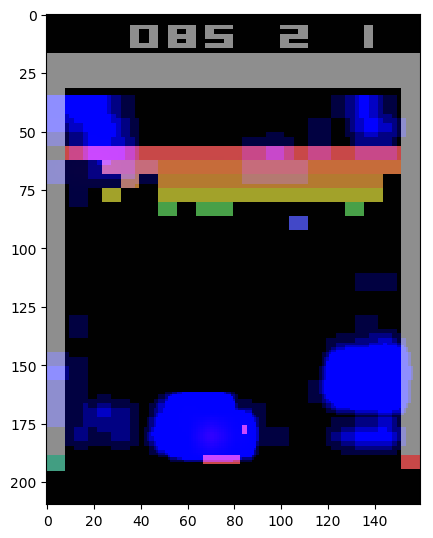

In [41]:
plt.figure(figsize=[11, 5*1.3], dpi=100)
plt.imshow(perturbation_map)

In [43]:
fig.set_size_inches(10, 15)
plt.imsave('test.png',perturbation_map, dpi=100)

# gen saliency maps and save 

In [53]:
store = h5py.File('model_rollouts.h5','r')

present = [i for i in range(1,100)]
for i in list(store[list(store.keys())[0]].keys()):
    num = int(i.split('.')[-2])
    if num in present:
        present.remove(num)
present

[15, 20]

In [55]:
store = h5py.File('model_rollouts.h5','r')

if not os.path.exists('images'):
    os.makedirs('images')

for iteration in range(1, 100)[14:]:
    print("running iteration ",iteration)
    
    if iteration==15 or iteration==20: # bad hot fix for now 
        continue
    
    ins = store['models_model7-02-17-20-41/model.'+str(iteration)+'.tar/history/ins'].value
    hx = store['models_model7-02-17-20-41/model.'+str(iteration)+'.tar/history/hx'].value
    history = {'ins':ins, 'hx':hx}

    meta = get_env_meta(env_name)
    env = gym.make(env_name) ; env.seed(1)
    model = NNPolicy(channels=1, num_actions=env.action_space.n, memsize=256)
    try:
        _ = model.try_load(load_dir, checkpoint='*.'+str(iteration)+'.tar') ; torch.manual_seed(1)
    except:
        print("exception at iteration: ",iteration)
        continue
    
    folder = os.path.join('images',str(iteration))
        
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    radius = 5
    density = 5
    
    for frame_ix in [500, 1000, 1500, 2000, 2500]:
        if frame_ix >= len(history['ins']):
            break
        actor_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='actor')
        critic_saliency = score_frame(model, history, frame_ix, radius, density, interp_func=occlude, mode='critic')
        frame = history['ins'][frame_ix].squeeze().copy()
        frame = saliency_on_atari_frame(actor_saliency, frame, fudge_factor=200, channel=2)
        perturbation_map = saliency_on_atari_frame(critic_saliency, frame, fudge_factor=100, channel=0)
        
        plt.imsave(os.path.join(folder, str(frame_ix)), perturbation_map)    
        print("saved {}th frame & sal-map", frame_ix)

running iteration  15
running iteration  16
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.16.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
running iteration  17
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.17.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  18
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.18.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  19
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.19.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  20
running iteration  21
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.21.tar
saved {}th frame & sal-map 500
saved {}th fr

saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  58
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.58.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
running iteration  59
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.59.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  60
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.60.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
running iteration  61
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.61.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 15

saved {}th frame & sal-map 1500
running iteration  95
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.95.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
running iteration  96
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.96.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  97
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.97.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
running iteration  98
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model.98.tar
saved {}th frame & sal-map 500
saved {}th frame & sal-map 1000
saved {}th frame & sal-map 1500
saved {}th frame & sal-map 2000
saved {}th frame & sal-map 2500
running iteration  99
	loaded model: ../baby-a3c/breakout-v4/models_model7-02-17-20-41/model

## Plot side-by-side

NameError: name 'jacobian_map' is not defined

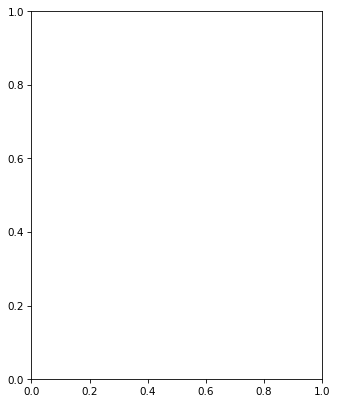

In [13]:
f = plt.figure(figsize=[11, 5*1.3], dpi=75)

plt.subplot(1,2,1)
plt.imshow(jacobian_map)
plt.title('Jacobian', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(perturbation_map)
plt.title('Ours', fontsize=30)

for a in f.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False)
plt.show() #; f.savefig('./figures/jacobian-vs-perturb.png', bbox_inches='tight')